In [4]:
%matplotlib inline
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from matplotlib.colors import LinearSegmentedColormap
from scipy import stats
import scikit_posthocs as sp
import sys

In [84]:
matrixMalEX="data_GG.csv"
matrixMal="data_GM.csv"
matrixIt="data_L.csv"
matrixIt_Total="data_L_Total.csv"
n_qty=2 #CAMBIAR SEGUN LA CANTIDAD DE NODOS USADOS
n_groups= 2
repet = 10 #CAMBIAR EL PRIMER NUMERO SEGUN NUMERO DE EJECUCIONES POR CONFIG

p_value = 0.05
values = [2, 10, 20, 40]
#                      WORST          BEST
dist_names = ['null', 'BalancedFit', 'CompactFit']

processes = [1,10,20,40,80,120]

labelsP = [['(2,2)', '(2,10)', '(2,20)', '(2,40)'],['(10,2)', '(10,10)', '(10,20)', '(10,40)'],
          ['(20,2)', '(20,10)', '(20,20)', '(20,40)'],['(40,2)', '(40,10)', '(40,20)', '(40,40)']]
labelsP_J = ['(2,2)', '(2,10)', '(2,20)', '(2,40)','(10,2)', '(10,10)', '(10,20)', '(10,40)',
              '(20,2)', '(20,10)', '(20,20)', '(20,40)','(40,2)', '(40,10)', '(40,20)', '(40,40)']
positions = [321, 322, 323, 324, 325]
positions_small = [221, 222, 223, 224]

In [85]:
dfG = pd.read_csv( matrixMalEX )

dfG = dfG.drop(columns=dfG.columns[0])
dfG['S'] = dfG['N']
dfG['N'] = dfG['S'] + dfG['%Async']
dfG['%Async'] = (dfG['%Async'] / dfG['N']) * 100
dfG['%Async'] = dfG['%Async'].fillna(0)

if(n_qty == 1):
    group = dfG.groupby(['%Async', 'Cst', 'Css', 'Groups'])['TE']
    group2 = dfG.groupby(['%Async', 'Cst', 'Css', 'NP','NS'])['TE']
else:        
    group = dfG.groupby(['Dist', '%Async', 'Cst', 'Css', 'Groups'])['TE']
    group2 = dfG.groupby(['Dist', '%Async', 'Cst', 'Css', 'NP','NS'])['TE']

grouped_aggG = group.agg(['median'])
grouped_aggG.rename(columns={'median':'TE'}, inplace=True)

grouped_aggG2 = group2.agg(['median'])
grouped_aggG2.rename(columns={'median':'TE'}, inplace=True)

In [86]:
dfM = pd.read_csv( matrixMal )
dfM = dfM.drop(columns=dfM.columns[0])

dfM['S'] = dfM['N']
dfM['N'] = dfM['S'] + dfM['%Async']
dfM["TR"] = dfM["TC"] + dfM["TH"] + dfM["TS"] + dfM["TA"]
dfM['%Async'] = (dfM['%Async'] / dfM['N']) * 100

dfM['%Async'] = dfM['%Async'].fillna(0)
dfM['alpha'] = 1

#dfM = dfM.drop(dfM.loc[(dfM["Cst"] == 3) & (dfM["Css"] == 1) & (dfM["NP"] > dfM["NS"])].index)
#dfM = dfM.drop(dfM.loc[(dfM["Cst"] == 2) & (dfM["Css"] == 1) & (dfM["NP"] > dfM["NS"])].index)

if(n_qty == 1):
    groupM = dfM.groupby(['%Async', 'Cst', 'Css', 'NP', 'NS'])['TC', 'TH', 'TS', 'TA', 'TR', 'alpha']
else:
    groupM = dfM.groupby(['Dist', '%Async', 'Cst', 'Css', 'NP', 'NS'])['TC', 'TH', 'TS', 'TA', 'TR', 'alpha']

#group
grouped_aggM = groupM.agg(['median'])
grouped_aggM.columns = grouped_aggM.columns.get_level_values(0)

for cst_aux in [1,3]:
    for css_aux in [0,1]:
        for np_aux in processes:
            for ns_aux in processes:
                if np_aux != ns_aux:
                    grouped_aggM.loc[('2,2',0, cst_aux, css_aux, np_aux,ns_aux)]['alpha'] = \
                        grouped_aggM.loc[('2,2',0, cst_aux, css_aux, np_aux,ns_aux)]['TC'] / \
                        grouped_aggM.loc[('2,2',0, cst_aux-1, css_aux, np_aux,ns_aux)]['TC']
                    

/tmp/ipykernel_3862/2056908859.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  groupM = dfM.groupby(['Dist', '%Async', 'Cst', 'Css', 'NP', 'NS'])['TC', 'TH', 'TS', 'TA', 'TR', 'alpha']


In [87]:
dfL = pd.read_csv( matrixIt )
dfL = dfL.drop(columns=dfL.columns[0])

dfL['%Async'] = dfL['%Async'].fillna(0)
dfL['alpha'] = 1

#dfL = dfL.drop(dfL.loc[(dfL["Cst"] == 3) & (dfL["Css"] == 1) & (dfL["NP"] > dfL["NS"])].index)
#dfL = dfL.drop(dfL.loc[(dfL["Cst"] == 2) & (dfL["Css"] == 1) & (dfL["NP"] > dfL["NS"])].index)

if(n_qty == 1):
    groupL = dfL[dfL['NS'] != 0].groupby(['Tt', '%Async', 'Cst', 'Css', 'NP', 'NS'])['Ti', 'To', 'alpha']
else:
    groupL = dfL[dfL['NS'] != 0].groupby(['Tt', 'Dist', '%Async', 'Cst', 'Css', 'NP', 'NS'])['Ti', 'To', 'alpha']

#group
grouped_aggL = groupL.agg(['median', 'count'])
grouped_aggL.columns = grouped_aggL.columns.get_level_values(0)
grouped_aggL.set_axis(['Ti', 'Iters', 'To', 'Iters2', 'alpha', 'alpha2'], axis='columns', inplace=True)
grouped_aggL['Iters'] = np.round(grouped_aggL['Iters']/repet)
grouped_aggL['Iters2'] = np.round(grouped_aggL['Iters2']/repet)

for cst_aux in [1,3]:
    for css_aux in [0,1]:
        for np_aux in processes:
            for ns_aux in processes:
                if np_aux != ns_aux:
                    grouped_aggL.loc[(1,2,0, cst_aux, css_aux, np_aux,ns_aux), 'alpha'] = \
                        grouped_aggL.loc[(1,2,0, cst_aux, css_aux, np_aux,ns_aux)]['Ti'] / \
                        grouped_aggL.loc[(0,2,0, cst_aux, css_aux, np_aux,ns_aux)]['Ti']

/tmp/ipykernel_3862/3029782824.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  groupL = dfL[dfL['NS'] != 0].groupby(['Tt', 'Dist', '%Async', 'Cst', 'Css', 'NP', 'NS'])['Ti', 'To', 'alpha']


In [88]:
dfLT = pd.read_csv( matrixIt_Total )
dfLT = dfLT.drop(columns=dfLT.columns[0])

dfLT['%Async'] = dfLT['%Async'].fillna(0)

#dfL = dfL.drop(dfL.loc[(dfL["Cst"] == 3) & (dfL["Css"] == 1) & (dfL["NP"] > dfL["NS"])].index)
#dfL = dfL.drop(dfL.loc[(dfL["Cst"] == 2) & (dfL["Css"] == 1) & (dfL["NP"] > dfL["NS"])].index)

if(n_qty == 1):
    groupLT = dfLT[dfLT['NS'] != 0].groupby(['%Async', 'Cst', 'Css', 'NP', 'NS'])['Sum']
else:
    groupLT = dfLT[dfLT['NS'] != 0].groupby(['Dist', '%Async', 'Cst', 'Css', 'NP', 'NS'])['Sum']

#group
grouped_aggLT = groupLT.agg(['median'])
grouped_aggLT.columns = grouped_aggLT.columns.get_level_values(0)
grouped_aggLT.set_axis(['Sum'], axis='columns', inplace=True)

In [97]:
coherent_check_df = grouped_aggL.copy()
# Añadir suma total de iteraciones
coherent_check_df['Sum'] = 0
coherent_check_df.loc[(1,slice(None)),'Sum'] = grouped_aggLT[(grouped_aggLT['Sum'] != 0)].loc[(slice(None)),'Sum'].values
coherent_check_df = coherent_check_df[(coherent_check_df['Sum'] != 0)]
# Añadir tiempos TE y TC
coherent_check_df['TE'] = 0
coherent_check_df['TEA'] = 0
coherent_check_df['TR'] = 0
coherent_check_df['TRA'] = 0
for cst_aux in [1,3]:
    coherent_check_df.loc[(1,2,0,cst_aux,slice(None)),'TE'] = grouped_aggG2.loc[('2,2',0,cst_aux-1,slice(None)),'TE'].values
    coherent_check_df.loc[(1,2,0,cst_aux,slice(None)),'TR'] = grouped_aggM.loc[('2,2',0,cst_aux-1,slice(None)),'TC'].values
    coherent_check_df.loc[(1,2,0,cst_aux,slice(None)),'TEA'] = grouped_aggG2.loc[('2,2',0,cst_aux,slice(None)),'TE'].values
    coherent_check_df.loc[(1,2,0,cst_aux,slice(None)),'TRA'] = grouped_aggM.loc[('2,2',0,cst_aux,slice(None)),'TC'].values
# Calcular tiempos teoricos
#coherent_check_df['Teorico-S'] = coherent_check_df['Ti'] * 3 + coherent_check_df['TR'] +  TIEMPOITERNS * 97
#coherent_check_df['Rel-S'] = np.round(coherent_check_df['Teorico-S'] / coherent_check_df['TE'],2)
#coherent_check_df['Teorico-A'] = coherent_check_df['Ti'] * 3 + coherent_check_df['Sum'] +  TIEMPOITERNS * (97 - coherent_check_df['Iters'])
#coherent_check_df['Rel-A'] = np.round(coherent_check_df['Teorico-A'] / coherent_check_df['TEA'],2)
coherent_check_df=coherent_check_df.droplevel('Tt').droplevel('%Async').droplevel('Dist')
for cst_aux in [1,3]:
    for css_aux in [0,1]:
        aux_df = coherent_check_df.loc[(cst_aux, css_aux, slice(None))]
        aux_df.to_excel("coherent"+str(cst_aux)+"_"+str(css_aux)+".xlsx")

In [90]:
grouped_aggL.to_excel("resultL.xlsx") 
grouped_aggLT.to_excel("resultLT.xlsx")
dfLT.to_excel("resultLT_all.xlsx")
grouped_aggM.to_excel("resultM.xlsx") 
grouped_aggG2.to_excel("resultG.xlsx") 

In [91]:
dfG

Unnamed: 0  N  %Async  Groups   NP  NS Dist  Matrix  CommTam  Cst  Css  \
0              0  0     0.0   40,10   40  10  2,2  100000        0    3    0   
1              1  0     0.0   40,10   40  10  2,2  100000        0    3    0   
2              2  0     0.0   40,10   40  10  2,2  100000        0    3    0   
3              3  0     0.0   40,10   40  10  2,2  100000        0    3    0   
4              4  0     0.0   40,10   40  10  2,2  100000        0    3    0   
...          ... ..     ...     ...  ...  ..  ...     ...      ...  ...  ...   
2395         795  0     0.0  120,10  120  10  2,2  100000        0    3    0   
2396         796  0     0.0  120,10  120  10  2,2  100000        0    3    0   
2397         797  0     0.0  120,10  120  10  2,2  100000        0    3    0   
2398         798  0     0.0  120,10  120  10  2,2  100000        0    3    0   
2399         799  0     0.0  120,10  120  10  2,2  100000        0    3    0   

      Time Iters         TE  S  
0      4.0  3,97  38.877059  0  
1      4.0  3,97  38.888270  0  
2      4.0  3,97  38.902969  0  
3      4.0  3,97  38.575118  0  
4      4.0  3,97  38.733319  0  
...    ...   ...        ... ..  
2395   4.0  3,97  38.333576  0  
2396   4.0  3,97  38.551992  0  
2397   4.0  3,97  38.096905  0  
2398   4.0  3,97  38.306287  0  
2399   4.0  3,97  35.718237  0  

[2400 rows x 15 columns]

In [92]:
grouped_aggG

TE
Dist %Async Cst Css Groups            
2,2  0.0    0   0   1,10     51.155089
                    1,120    16.272649
                    1,20     32.424268
                    1,40     22.743039
                    1,80     18.062010
...                                ...
            3   1   80,1    380.120240
                    80,10    38.421356
                    80,120    4.226927
                    80,20    19.435148
                    80,40     9.988482

[240 rows x 1 columns]

In [93]:
dfM

Unnamed: 0  N  %Async   NP  NS Dist  Matrix  CommTam  Cst  Css  Time  \
0              0  0     0.0   40  10  2,2  100000        0    3    0   4.0   
1              1  0     0.0   40  10  2,2  100000        0    3    0   4.0   
2              2  0     0.0   40  10  2,2  100000        0    3    0   4.0   
3              3  0     0.0   40  10  2,2  100000        0    3    0   4.0   
4              4  0     0.0   40  10  2,2  100000        0    3    0   4.0   
...          ... ..     ...  ...  ..  ...     ...      ...  ...  ...   ...   
2395         795  0     0.0  120  10  2,2  100000        0    3    0   4.0   
2396         796  0     0.0  120  10  2,2  100000        0    3    0   4.0   
2397         797  0     0.0  120  10  2,2  100000        0    3    0   4.0   
2398         798  0     0.0  120  10  2,2  100000        0    3    0   4.0   
2399         799  0     0.0  120  10  2,2  100000        0    3    0   4.0   

     Iters        TC   TH   TS   TA  S        TR  alpha  
0     3,97  0.164909  0.0  0.0  0.0  0  0.164909      1  
1     3,97  0.153193  0.0  0.0  0.0  0  0.153193      1  
2     3,97  0.166233  0.0  0.0  0.0  0  0.166233      1  
3     3,97  0.294920  0.0  0.0  0.0  0  0.294920      1  
4     3,97  0.384164  0.0  0.0  0.0  0  0.384164      1  
...    ...       ...  ...  ...  ... ..       ...    ...  
2395  3,97  0.180204  0.0  0.0  0.0  0  0.180204      1  
2396  3,97  0.395571  0.0  0.0  0.0  0  0.395571      1  
2397  3,97  0.333766  0.0  0.0  0.0  0  0.333766      1  
2398  3,97  0.171306  0.0  0.0  0.0  0  0.171306      1  
2399  3,97  1.258483  0.0  0.0  0.0  0  1.258483      1  

[2400 rows x 19 columns]

In [94]:
grouped_aggM

TC   TH   TS   TA        TR     alpha
Dist %Async Cst Css NP  NS                                              
2,2  0.0    0   0   1   10   0.315527  0.0  0.0  0.0  0.315527  1.000000
                        20   0.860505  0.0  0.0  0.0  0.860505  1.000000
                        40   0.861425  0.0  0.0  0.0  0.861425  1.000000
                        80   0.988951  0.0  0.0  0.0  0.988951  1.000000
                        120  0.911823  0.0  0.0  0.0  0.911823  1.000000
...                               ...  ...  ...  ...       ...       ...
            3   1   120 1    0.360395  0.0  0.0  0.0  0.360395  1.550456
                        10   0.428876  0.0  0.0  0.0  0.428876  2.692918
                        20   0.463684  0.0  0.0  0.0  0.463684  2.264129
                        40   0.265142  0.0  0.0  0.0  0.265142  0.864532
                        80   0.402624  0.0  0.0  0.0  0.402624  0.987730

[240 rows x 6 columns]

In [95]:
dfL

Unnamed: 0  N  %Async   NP  N_par  NS  Dist  Compute_tam  Comm_tam  \
0                0  0     0.0   40      0  10     2       100000         0   
1                1  0     0.0   40      0  10     2       100000         0   
2                2  0     0.0   40      0  10     2       100000         0   
3                3  0     0.0   40      0  10     2       100000         0   
4                4  0     0.0   40      0  10     2       100000         0   
...            ... ..     ...  ...    ...  ..   ...          ...       ...   
239995       79995  0     0.0  120      0  10     2       100000         0   
239996       79996  0     0.0  120      0  10     2       100000         0   
239997       79997  0     0.0  120      0  10     2       100000         0   
239998       79998  0     0.0  120      0  10     2       100000         0   
239999       79999  0     0.0  120      0  10     2       100000         0   

        Cst  Css  Time  Iters        Ti   Tt     To  alpha  
0         3    0   4.0      3  0.099020  0.0  111.0      1  
1         3    0   4.0      3  0.099135  0.0  111.0      1  
2         3    0   4.0      3  0.099047  0.0  111.0      1  
3         3    0   4.0      3  0.162832  1.0  111.0      1  
4         3    0   4.0      3  0.100171  0.0  112.0      1  
...     ...  ...   ...    ...       ...  ...    ...    ...  
239995    3    0   4.0      3  0.103281  1.0   37.0      1  
239996    3    0   4.0      3  0.093780  1.0   37.0      1  
239997    3    0   4.0      3  0.107831  1.0   37.0      1  
239998    3    0   4.0      3  0.099046  1.0   37.0      1  
239999    3    0   4.0      3  0.065008  1.0   37.0      1  

[240000 rows x 17 columns]

In [96]:
grouped_aggL

Ti  Iters      To  Iters2     alpha  \
Tt  Dist %Async Cst Css NP  NS                                               
0.0 2    0.0    0   0   1   10   3.999165    3.0  4485.0     3.0  1.000000   
                            20   3.999194    3.0  4485.0     3.0  1.000000   
                            40   3.999186    3.0  4485.0     3.0  1.000000   
                            80   3.999236    3.0  4485.0     3.0  1.000000   
                            120  3.999194    3.0  4485.0     3.0  1.000000   
...                                   ...    ...     ...     ...       ...   
1.0 2    0.0    3   1   120 1    0.070046    3.0    37.0     3.0  2.108073   
                            10   0.075896    4.0    37.0     4.0  2.292376   
                            20   0.090617    5.0    37.0     5.0  2.733503   
                            40   0.069103    4.0    37.0     4.0  2.089061   
                            80   0.068959    4.0    37.0     4.0  2.083952   

                                 alpha2  
Tt  Dist %Async Cst Css NP  NS           
0.0 2    0.0    0   0   1   10       30  
                            20       30  
                            40       30  
                            80       30  
                            120      30  
...                                 ...  
1.0 2    0.0    3   1   120 1        30  
                            10       40  
                            20       54  
                            40       37  
                            80       39  

[360 rows x 6 columns]

In [19]:
grouped_aggLT

Sum
Dist %Async Cst Css NP NS          
2    0.0    0   0   1  10  0.000000
                       20  0.000000
                       40  0.000000
                       80  0.000000
                    10 1   0.000000
...                             ...
            3   1   40 80  1.427236
                    80 1   0.173856
                       10  0.207770
                       20  0.157496
                       40  0.184899

[160 rows x 1 columns]

In [14]:
auxIter = pd.DataFrame(dfM['Iters'].str.split(',',1).tolist(),columns = ['Iters0','Iters1'])
auxIter['Iters1'] = pd.to_numeric(auxIter['Iters1'], errors='coerce')
iters = auxIter['Iters1'].mean()
print(iters)


97.0


A partir de aquí se muestran gráficos

In [204]:
#Reserva de memoria para las estructuras
TP_data=[0]*2
TH_data=[0]*2
TM_data=[0]*2

TP_A_data=[0]*2
TH_A_data=[0]*2
TM_A_data=[0]*2

for dist in [1,2]:
    dist_index=dist-1
    
    TP_data[dist_index]=[0]*len(values)*(len(values))
    TH_data[dist_index]=[0]*len(values)*(len(values))
    TM_data[dist_index]=[0]*len(values)*(len(values))

    TP_A_data[dist_index]=[0]*len(values)*(len(values))
    TH_A_data[dist_index]=[0]*len(values)*(len(values))
    TM_A_data[dist_index]=[0]*len(values)*(len(values))

# Obtencion de los grupos del dataframe necesarios

#ACTUALMENTE NO SE DIFERENCIAN LOS TIEMPOS DE ITERACIONES DE PADRES E HIJOS CUANDO COINCIDE EL NUMERO DE PROCESOS
if(n_qty == 1):
    groupM_aux = dfM.groupby(['NP', 'NS'])['TC']
    groupL_aux = dfL[dfL['Tt'] == 0].groupby(['NP'])['Ti']
else:
    groupM_aux = dfM.groupby(['NP', 'NS', 'Dist'])['TC']
    groupL_aux = dfL[dfL['Tt'] == 0].groupby(['Dist', 'NP'])['Ti']

grouped_aggM_aux = groupM_aux.agg(['mean'])
grouped_aggM_aux.columns = grouped_aggM_aux.columns.get_level_values(0)

grouped_aggL_aux = groupL_aux.agg(['mean'])
grouped_aggL_aux.columns = grouped_aggL_aux.columns.get_level_values(0)
grouped_aggL_aux.set_axis(['Ti'], axis='columns')

#Calculo de los valores para las figuras
#1=Best Fit
#2=Worst Fit
dist=1
for dist in [1,2]:
    dist_index=dist-1
    dist_v = str(dist)+","+str(dist)
    i=0
    r=0
    for numP in values:
        j=0
        for numC in values:
        
            tc_real = grouped_aggM_aux.loc[(numP,numC,dist_v)]['mean']
            for tipo in [0]: #TODO Poner a 0,100
                iters_aux=dfM[(dfM["NP"] == numP)][(dfM["NS"] == numC)][(dfM["Dist"] == dist_v)][(dfM["%Async"] == tipo)]['Iters'].head(1).tolist()[0].split(',')
                itersP_aux = int(iters_aux[0])
                itersS_aux = int(iters_aux[1])
                iters_mal_aux = 0
                if tipo != 0:
                    iters_mal_aux = grouped_aggL['Iters'].loc[(1,dist,tipo,numP,numC)]
            
                t_iterP_aux = grouped_aggL_aux['Ti'].loc[(dist,numP)]
                t_iterS_aux = grouped_aggL_aux['Ti'].loc[(dist,numC)]
            
            
                p1 = t_iterP_aux * itersP_aux
                p2 = t_iterS_aux * max((itersS_aux - iters_mal_aux),0)
                
                array_aux = grouped_aggM[['TS', 'TA']].loc[(dist_v,tipo,numP,numC)].tolist()
                p3 = tc_real + array_aux[0] + array_aux[1]
                
                #Guardar datos
                if tipo == 0:
                    TP_data[dist_index][i*len(values) + j] = p1
                    TH_data[dist_index][i*len(values) + j] = p2
                    TM_data[dist_index][i*len(values) + j] = p3
                else:
                    TP_A_data[dist_index][i*len(values) + j] = p1
                    TH_A_data[dist_index][i*len(values) + j] = p2
                    TM_A_data[dist_index][i*len(values) + j] = p3
            j+=1
        i+=1
print(TP_data)
print(TH_data)
print(TM_data)

[[0.21241231578947362, 0.21241231578947362, 0.21241231578947362, 0.21241231578947362, 0.04632109565217393, 0.04632109565217393, 0.04632109565217393, 0.04632109565217393, 0.025296672413793103, 0.025296672413793103, 0.025296672413793103, 0.025296672413793103, 0.0355868547008547, 0.0355868547008547, 0.0355868547008547, 0.0355868547008547], [0.1981199732142857, 0.1981199732142857, 0.1981199732142857, 0.1981199732142857, 0.06233977876106192, 0.06233977876106192, 0.06233977876106192, 0.06233977876106192, 0.026912142857142853, 0.026912142857142853, 0.026912142857142853, 0.026912142857142853, 0.0343439649122807, 0.0343439649122807, 0.0343439649122807, 0.0343439649122807]]
[[2.1241231578947364, 0.4632109565217393, 0.25296672413793103, 0.35586854700854703, 2.1241231578947364, 0.4632109565217393, 0.25296672413793103, 0.35586854700854703, 2.1241231578947364, 0.4632109565217393, 0.25296672413793103, 0.35586854700854703, 2.1241231578947364, 0.4632109565217393, 0.25296672413793103, 0.3558685470085470

/home/usuario/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
/home/usuario/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


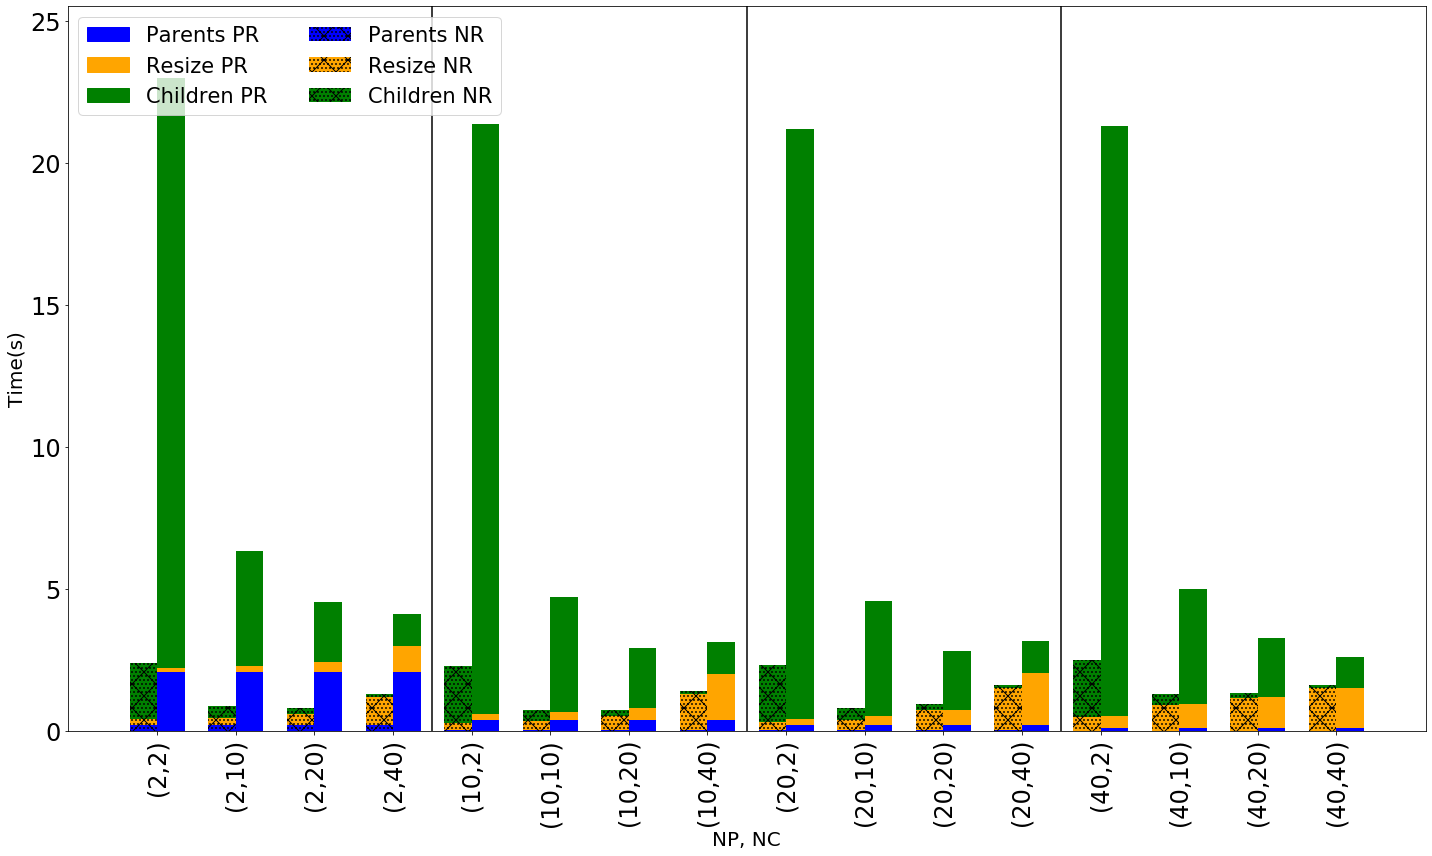

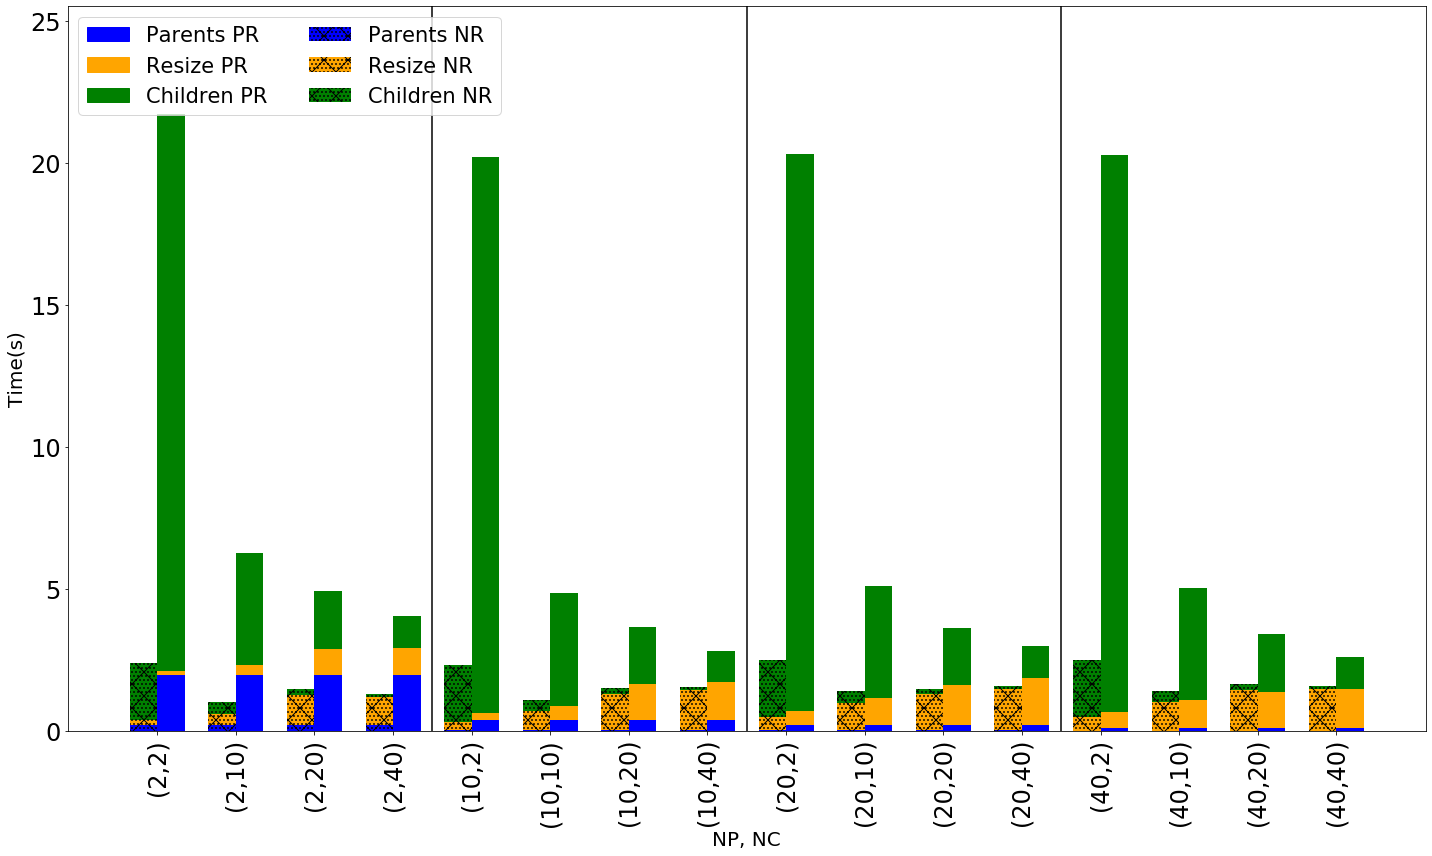

In [37]:
#TP_A_data=[[0.1997793257575758, 0.1997793257575758, 0.1997793257575758, 0.1997793257575758, 0.040469166666666695, 0.040469166666666695, 0.040469166666666695, 0.040469166666666695, 0.019951386363636366, 0.019951386363636366, 0.019951386363636366, 0.019951386363636366, 0.010227022727272729, 0.010227022727272729, 0.010227022727272729, 0.010227022727272729], [0.20020575000000002, 0.20020575000000002, 0.20020575000000002, 0.20020575000000002, 0.039894712121212116, 0.039894712121212116, 0.039894712121212116, 0.039894712121212116, 0.020662818181818185, 0.020662818181818185, 0.020662818181818185, 0.020662818181818185, 0.010635333333333332, 0.010635333333333332, 0.010635333333333332, 0.010635333333333332]]
#TH_A_data=[[1.9977932575757578, 0.40469166666666695, 0.19951386363636364, 0.10227022727272729, 1.9977932575757578, 0.40469166666666695, 0.19951386363636364, 0.10227022727272729, 1.9977932575757578, 0.40469166666666695, 0.19951386363636364, 0.10227022727272729, 1.9977932575757578, 0.40469166666666695, 0.19951386363636364, 0.10227022727272729], [2.0020575000000003, 0.39894712121212117, 0.20662818181818185, 0.10635333333333331, 2.0020575000000003, 0.39894712121212117, 0.20662818181818185, 0.10635333333333331, 2.0020575000000003, 0.39894712121212117, 0.20662818181818185, 0.10635333333333331, 2.0020575000000003, 0.39894712121212117, 0.20662818181818185, 0.10635333333333331]]
#TM_A_data=[[0.2083043333333333, 0.2661843333333333, 0.41778833333333326, 0.9868953333333335, 0.242685, 0.3060793333333333, 0.4986676666666667, 1.2530743333333334, 0.305179, 0.373607, 0.7375183333333334, 1.5113886666666667, 0.501651, 0.8987069999999999, 1.138518666666667, 1.5091376666666665], [0.205789, 0.4116923333333334, 1.0607546666666667, 0.9947066666666666, 0.27494700000000005, 0.669121, 1.2705783333333334, 1.3951336666666665, 0.4765406666666667, 0.9758123333333333, 1.267633, 1.4479673333333334, 0.4905743333333333, 1.0088953333333333, 1.4447113333333332, 1.4516683333333333]]


for dist in [1,2]:
    dist_index=dist-1
    f=plt.figure(figsize=(20, 12))
#for numP in values:

    x = np.arange(len(labelsP_J))

    width = 0.35
    sumaTP_TM = np.add(TP_data[dist_index], TM_data[dist_index]).tolist()
    sumaTP_TM_A = np.add(TP_A_data[dist_index], TM_A_data[dist_index]).tolist()

    ax=f.add_subplot(111)

    ax.bar(x+width/2, TP_data[dist_index], width, color='blue')
    ax.bar(x+width/2, TM_data[dist_index], width, bottom=TP_data[dist_index],color='orange')
    ax.bar(x+width/2, TH_data[dist_index], width, bottom=sumaTP_TM, color='green')

    ax.bar(x-width/2, TP_A_data[dist_index], width, hatch="\\/...", color='blue')
    ax.bar(x-width/2, TM_A_data[dist_index], width, bottom=TP_A_data[dist_index], hatch="\\/...", color='orange')
    ax.bar(x-width/2, TH_A_data[dist_index], width, bottom=sumaTP_TM_A, hatch="\\/...", color='green')

    ax.set_ylabel("Time(s)", fontsize=20)
    ax.set_xlabel("NP, NC", fontsize=20)
    plt.xticks(x, labelsP_J, rotation=90)

    blue_Spatch = mpatches.Patch(color='blue', label='Parents PR')
    orange_Spatch = mpatches.Patch(color='orange', label='Resize PR')
    green_Spatch = mpatches.Patch(color='green', label='Children PR')
    blue_Apatch = mpatches.Patch(hatch='\\/...', facecolor='blue', label='Parents NR')
    orange_Apatch = mpatches.Patch(hatch='\\/...', facecolor='orange', label='Resize NR')
    green_Apatch = mpatches.Patch(hatch='\\/...', facecolor='green', label='Children NR')


    handles=[blue_Spatch,orange_Spatch,green_Spatch,blue_Apatch,orange_Apatch,green_Apatch]

    plt.legend(handles=handles, loc='upper left', fontsize=21,ncol=2)
    
    ax.axvline((3.5), color='black')
    ax.axvline((7.5), color='black')
    ax.axvline((11.5), color='black')
    
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.tick_params(axis='both', which='minor', labelsize=22)
    plt.ylim((0, 25.5))
    #ax.axvline(4)
    
    f.tight_layout()
    f.savefig("Images/EX_Partitions_"+dist_names[dist]+".png", format="png")

In [98]:
labels = ['(1,10)', '(1,20)', '(1,40)','(1,80)','(1,120)',
            '(10,1)', '(10,20)', '(10,40)','(10,80)','(10,120)',
            '(20,1)',  '(20,10)','(20,40)','(20,80)','(20,120)',
            '(40,1)',  '(40,10)',  '(40,20)','(40,80)','(40,120)',
            '(80,1)',  '(80,10)',  '(80,20)', '(80,40)','(80,120)',
            '(120,1)', '(120,10)', '(120,20)','(120,40)','(120,80)']

labelsExpand = ['(1,10)', '(1,20)', '(1,40)','(1,80)','(1,120)',
               '(10,20)', '(10,40)','(10,80)','(10,120)',
               '(20,40)','(20,80)','(20,120)',
               '(40,80)','(40,120)',
               '(80,120)']
labelsShrink = ['(10,1)', 
               '(20,1)',  '(20,10)', 
               '(40,1)',  '(40,10)',  '(40,20)',
               '(80,1)',  '(80,10)',  '(80,20)', '(80,40)',
               '(120,1)', '(120,10)', '(120,20)','(120,40)','(120,80)']

labelsExpandIntra = ['(1,10)', '(1,20)','(10,20)']
labelsShrinkIntra = ['(10,1)', '(20,1)', '(20,10)']
labelsExpandInter = ['(1,40)','(1,80)', '(1,160)',
               '(10,40)','(10,80)', '(10,160)',
               '(20,40)','(20,80)', '(20,160)',
               '(40,80)', '(40,160)',
               '(80,160)']
labelsShrinkInter = ['(40,1)', '(40,10)', '(40,20)',
               '(80,1)', '(80,10)', '(80,20)','(80,40)',
               '(160,1)', '(160,10)', '(160,20)','(160,40)', '(160,80)']

                #0          #1                 #2                     #3
labelsMethods = ['Baseline', 'Baseline single','Baseline - Asyncrhonous','Baseline single - Asyncrhonous',
                 'Merge','Merge single','Merge - Asyncrhonous','Merge single - Asyncrhonous']
                 #4      #5             #6                 #7

OrMult_patch = mpatches.Patch(hatch='', facecolor='green', label='Baseline')
OrSing_patch = mpatches.Patch(hatch='', facecolor='springgreen', label='Baseline single')
OrPthMult_patch = mpatches.Patch(hatch='//', facecolor='blue', label='Baseline - Asyncrhonous')
OrPthSing_patch = mpatches.Patch(hatch='\\', facecolor='darkblue', label='Baseline single - Asyncrhonous')
MergeMult_patch = mpatches.Patch(hatch='||', facecolor='red', label='Merge')
MergeSing_patch = mpatches.Patch(hatch='...', facecolor='darkred', label='Merge single')
MergePthMult_patch = mpatches.Patch(hatch='xx', facecolor='yellow', label='Merge - Asyncrhonous')
MergePthSing_patch = mpatches.Patch(hatch='++', facecolor='olive', label='Merge single - Asyncrhonous')

In [10]:
labels = ['(1,10)', '(1,20)', '(1,40)','(1,80)',
            '(10,1)', '(10,20)', '(10,40)','(10,80)',
            '(20,1)',  '(20,10)','(20,40)','(20,80)',
            '(40,1)',  '(40,10)',  '(40,20)','(40,80)',
            '(80,1)',  '(80,10)',  '(80,20)', '(80,40)']

labelsExpand = ['(1,10)', '(1,20)', '(1,40)','(1,80)',
               '(10,20)', '(10,40)','(10,80)',
               '(20,40)','(20,80)',
               '(40,80)']
labelsShrink = ['(10,1)', 
               '(20,1)',  '(20,10)', 
               '(40,1)',  '(40,10)',  '(40,20)',
               '(80,1)',  '(80,10)',  '(80,20)', '(80,40)']

labelsExpandIntra = ['(1,10)', '(1,20)','(10,20)']
labelsShrinkIntra = ['(10,1)', '(20,1)', '(20,10)']
labelsExpandInter = ['(1,40)','(1,80)',
               '(10,40)','(10,80)',
               '(20,40)','(20,80)',
               '(40,80)']
labelsShrinkInter = ['(40,1)', '(40,10)', '(40,20)',
               '(80,1)', '(80,10)', '(80,20)','(80,40)']

                #0          #1                 #2                     #3
labelsMethods = ['Baseline', 'Baseline single','Baseline - Asyncrhonous','Baseline single - Asyncrhonous',
                 'Merge','Merge single','Merge - Asyncrhonous','Merge single - Asyncrhonous']
                 #4      #5             #6                 #7

OrMult_patch = mpatches.Patch(hatch='', facecolor='green', label='Baseline')
OrSing_patch = mpatches.Patch(hatch='', facecolor='springgreen', label='Baseline single')
OrPthMult_patch = mpatches.Patch(hatch='//', facecolor='blue', label='Baseline - Asyncrhonous')
OrPthSing_patch = mpatches.Patch(hatch='\\', facecolor='darkblue', label='Baseline single - Asyncrhonous')
MergeMult_patch = mpatches.Patch(hatch='||', facecolor='red', label='Merge')
MergeSing_patch = mpatches.Patch(hatch='...', facecolor='darkred', label='Merge single')
MergePthMult_patch = mpatches.Patch(hatch='xx', facecolor='yellow', label='Merge - Asyncrhonous')
MergePthSing_patch = mpatches.Patch(hatch='++', facecolor='olive', label='Merge single - Asyncrhonous')

In [11]:
def get_types_iker(checked_type='tc', used_direction='e', node_type="All", normality='m'):
    if checked_type=='te':
        var_aux='TE'
        tipo_fig="TE"
        grouped_aux=grouped_aggG2
    elif checked_type=='tc':
        var_aux='TC'
        tipo_fig="Mall"
        grouped_aux=grouped_aggM
    
    if node_type=='Intra':
        grouped_aux=grouped_aux.query('NP < 21 and NS < 21')
    elif node_type=='Inter':
        grouped_aux=grouped_aux.query('NP > 21 or NS > 21')

    if used_direction=='s':
        grouped_aux=grouped_aux.query('NP > NS')
        if node_type=='Intra':
            used_labels=labelsShrinkIntra
        elif node_type=='Inter':
            used_labels=labelsShrinkInter
        elif node_type=='All':
            used_labels=labelsShrink
        name_fig="Shrink"
        
        if normality=='r':
            handles=[OrSing_patch,OrPthMult_patch,OrPthSing_patch,MergeMult_patch,MergePthMult_patch]
        else:
            handles=[OrMult_patch,OrSing_patch,OrPthMult_patch,OrPthSing_patch,MergeMult_patch,MergePthMult_patch]
    elif used_direction=='e':
        grouped_aux=grouped_aux.query('NP < NS')
        if node_type=='Intra':
            used_labels=labelsExpandIntra
        elif node_type=='Inter':
            used_labels=labelsExpandInter
        elif node_type=='All':
            used_labels=labelsExpand
        name_fig="Expand"
        if normality=='r':
            handles=[OrSing_patch,OrPthMult_patch,OrPthSing_patch,MergeMult_patch,MergeSing_patch,MergePthMult_patch,MergePthSing_patch]
        else:
            handles=[OrMult_patch,OrSing_patch,OrPthMult_patch,OrPthSing_patch,MergeMult_patch,MergeSing_patch,MergePthMult_patch,MergePthSing_patch]
    title=tipo_fig+"_Spawn_"+node_type+"_"+name_fig+"_"+normality
    return var_aux, grouped_aux, handles, used_labels, title

In [12]:
def obtain_arrays_iker(grouped_aux, var_aux, used_direction='e', normality='m'):
    vOrMult = list(grouped_aux.query('Cst == 0 and Css == 0')[var_aux])
    vOrSingle = list(grouped_aux.query('Cst == 0 and Css == 1')[var_aux])
    vMergeMult = list(grouped_aux.query('Cst == 2 and Css == 0')[var_aux])
    vOrPthMult = list(grouped_aux.query('Cst == 1 and Css == 0')[var_aux])
    vOrPthSingle = list(grouped_aux.query('Cst == 1 and Css == 1')[var_aux])
    vMergePthMult = list(grouped_aux.query('Cst == 3 and Css == 0')[var_aux])
    h_line = None
    
    if used_direction=='e':
        vMergeSingle = list(grouped_aux.query('Cst == 2 and Css == 1')[var_aux])
        vMergePthSingle = list(grouped_aux.query('Cst == 3 and Css == 1')[var_aux])
    else:
        #FIXME Que tenga en cuenta TH al realizar shrink merge
        vMergePthMult = list(grouped_aux.query('Cst == 3 and Css == 0')[var_aux])
        vMergeSingle = None
        vMergePthSingle = None
    title_y = "Total time(s)"
        
    if normality == 'r':
        vOrSingle = np.subtract(vOrMult, vOrSingle)
        vOrPthMult = np.subtract(vOrMult, vOrPthMult)
        vOrPthSingle = np.subtract(vOrMult, vOrPthSingle)
        vMergeMult = np.subtract(vOrMult, vMergeMult)
        vMergePthMult = np.subtract(vOrMult, vMergePthMult)
        if used_direction=='e':
            vMergeSingle = np.subtract(vOrMult, vMergeSingle)
            vMergePthSingle = np.subtract(vOrMult, vMergePthSingle)
        vOrMult = None
        h_line = 0
        title_y = "Saved time(s)"
    elif normality == 'n':
        vOrSingle = np.divide(vOrSingle, vOrMult)
        vOrPthMult = np.divide(vOrPthMult, vOrMult)
        vOrPthSingle = np.divide(vOrPthSingle, vOrMult)
        vMergeMult = np.divide(vMergeMult, vOrMult)
        vMergePthMult = np.divide(vMergePthMult, vOrMult)
        if used_direction=='e':
            vMergeSingle = np.divide(vMergeSingle, vOrMult)
            vMergePthSingle = np.divide(vMergePthSingle, vOrMult)
        vOrMult = np.divide(vOrMult, vOrMult)
        h_line = 1
        title_y = "Relation Config time / Baseline Time"
    
    data_array=[vOrMult,vOrSingle,vOrPthMult,vOrPthSingle,vMergeMult,vMergeSingle,vMergePthMult,vMergePthSingle]
    v_lines=[]
    value_aux = 0.4
    if used_direction == 'e':
        value_aux = 0.5
    for i in range(0, len(vOrSingle)-1):
        v_lines.append(value_aux + i)
    return data_array, title_y, v_lines, h_line



In [13]:
def legend_loc_iker(data_array, len_x, ylim_zero):
    
    max_value = np.nanmax([x for x in data_array if x is not None]) # Los valores None es necesario evitarlos
    min_value = np.nanmin([x for x in data_array if x is not None]) # Los valores None es necesario evitarlos
    if(ylim_zero):
        min_value = 0
    middle_value = (max_value + min_value) / 2
    offset = (max_value - min_value) * 0.1
    
    def array_check_loc(ini, end):
        up = True
        lower = True
        for i in range(ini, end):
            for j in range(len(data_array)):
                if not (data_array[j] is None):
                    if data_array[j][i] > (middle_value + offset):
                        up = False
                    elif data_array[j][i] < (middle_value - offset):
                        lower = False
                    if not up and not lower:
                        break
            else:
                continue # Only executed if inner loop did NOT break
            break # Only executed if inner loop did break
        return up,lower
    
    up_left, lower_left = array_check_loc(0, math.floor(len_x/2))
    up_right, lower_right = array_check_loc(0, math.floor(len_x/2))

    legend_loc = 'best'
    if up_left:
        legend_loc = 'upper left'
    elif up_right:
        legend_loc = 'upper right'
    elif lower_left:
        legend_loc = 'lower left'
    elif lower_right:
        lower_right = 'lower right'

    return legend_loc
        

In [14]:
def graphic_iker(data_array, title="None", title_y="None", title_x="None", handles=None, used_labels=None, v_lines=None, h_line=None, ylim_zero=True):
    f=plt.figure(figsize=(30, 12))
    ax=f.add_subplot(111)
    x = np.arange(len(used_labels))
    width = 0.45/4
    
    legend_loc = legend_loc_iker(data_array, len(used_labels), ylim_zero)

    if not (data_array[0] is None):
        ax.bar(x-width*3.5, data_array[0], width, color='green')
    ax.bar(x-width*2.5, data_array[1], width, hatch="", color='springgreen')
    ax.bar(x-width*1.5, data_array[2], width, hatch="//", color='blue')
    ax.bar(x-width*0.5, data_array[3], width, hatch="\\",color='darkblue')

    ax.bar(x+width*0.5, data_array[4], width, hatch="||", color='red')
    if not (data_array[5] is None):
        ax.bar(x+width*1.5, data_array[5], width, hatch="...", color='darkred')
        ax.bar(x+width*2.5, data_array[6], width, hatch="xx", color='yellow')
    else:
        ax.bar(x+width*1.5, data_array[6], width, hatch="xx", color='yellow')
    if not (data_array[7] is None):
        ax.bar(x+width*3.5, data_array[7], width, hatch="++",color='olive')

    ax.axhline((0), color='black', linestyle='dashed')
    ax.set_ylabel(title_y, fontsize=30)
    ax.set_xlabel(title_x, fontsize=28)
    plt.xticks(x, used_labels, rotation=90)
    plt.legend(handles=handles, loc=legend_loc, fontsize=26,ncol=2,framealpha=1)
    
    if not ylim_zero: # Modifica los limites del eje y. No es buena practica que no aparezca el 0
        max_value = np.nanmax([x for x in data_array if x is not None]) # Los valores None es necesario evitarlos
        max_value += max_value * 0.1
        min_value = np.nanmin([x for x in data_array if x is not None]) # Los valores None es necesario evitarlos
        min_value -= min_value * 0.1
        if min_value < 0.1:
            min_value = 0
        plt.ylim((min_value, max_value))
    
    for line in v_lines:
        ax.axvline((line), color='black')
    if h_line != None:
        ax.axhline((h_line), color='black')
    
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=28)
    
    f.tight_layout()
    f.savefig("Images/Spawn/"+title+".png", format="png")

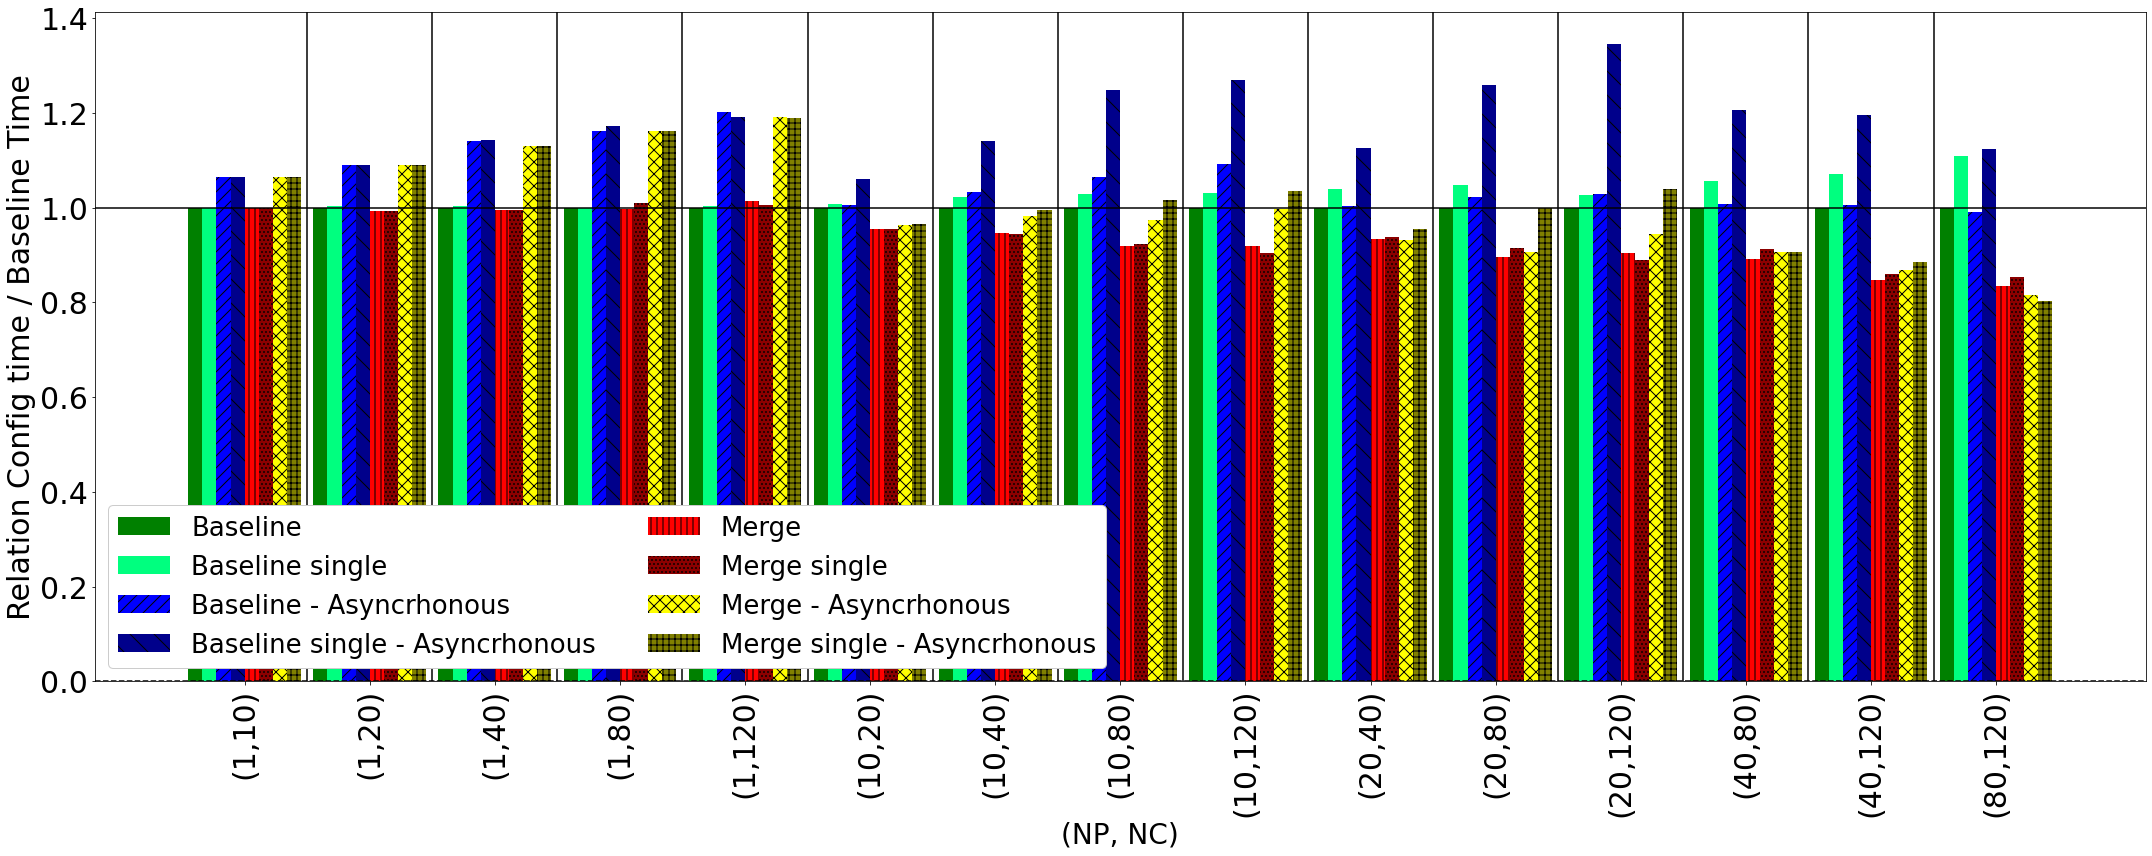

In [102]:
checked_type='te' # Valores 'te' y 'tc'
used_direction='e' # Valores 's' y 'e'
node_type='All' # Valores 'Intra', 'Inter', 'All'
normality='n'
#Values 'n' (normalizar), 'l' (logaritmico), 'm' (sin modificaciones), 'r' (Comparar respecto al primero)

ylim_zero = True

var_aux, grouped_aux, handles, used_labels, title = get_types_iker(checked_type, used_direction, node_type, normality)
array_aux, title_y, v_lines, h_line = obtain_arrays_iker(grouped_aux, var_aux, used_direction, normality)
graphic_iker(array_aux, title, title_y, "(NP, NC)", handles, used_labels, v_lines, ylim_zero)

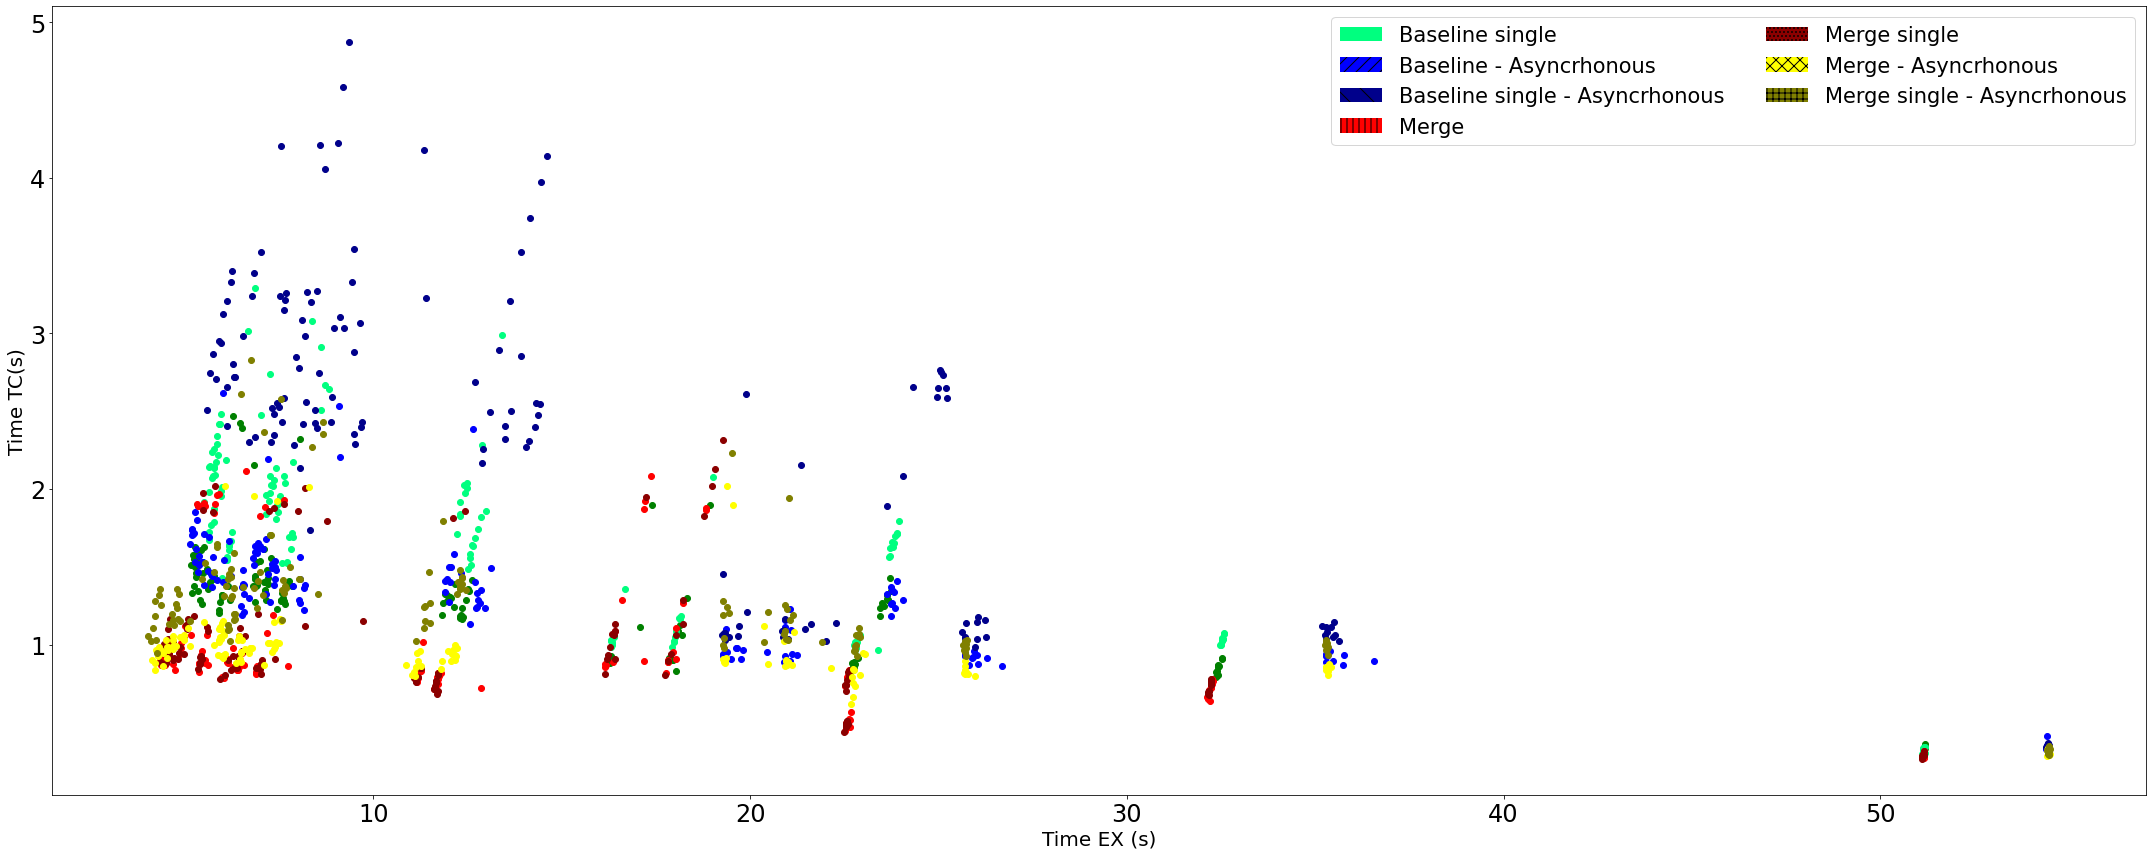

In [104]:
used_direction='e'
    
if used_direction=='s':
    dfM_aux=dfM.query('NP > NS')
    dfG_aux=dfG.query('NP > NS')
    used_labels=labelsShrink
    name_fig="Shrink"
    handles=[OrSing_patch,OrPthMult_patch,OrPthSing_patch,MergeMult_patch,MergePthMult_patch]
elif used_direction=='e':
    dfM_aux=dfM.query('NP < NS')
    dfG_aux=dfG.query('NP < NS')
    used_labels=labelsExpand
    name_fig="Expand"
    handles=[OrSing_patch,OrPthMult_patch,OrPthSing_patch,MergeMult_patch,MergeSing_patch,MergePthMult_patch,MergePthSing_patch]
# < Expand
# > Shrink

vOrMult = list(dfG_aux.query('Cst == 0 and Css == 0')['TE'])
vOrSingle = list(dfG_aux.query('Cst == 0 and Css == 1')['TE'])
vOrPthMult = list(dfG_aux.query('Cst == 1 and Css == 0')['TE'])
vOrPthSingle = list(dfG_aux.query('Cst == 1 and Css == 1')['TE'])

vMergeMult = list(dfG_aux.query('Cst == 2 and Css == 0')['TE'])
vMergeSingle = list(dfG_aux.query('Cst == 2 and Css == 1')['TE'])
vMergePthMult = list(dfG_aux.query('Cst == 3 and Css == 0')['TE'])
vMergePthSingle = list(dfG_aux.query('Cst == 3 and Css == 1')['TE'])

vOrMult2 = list(dfM_aux.query('Cst == 0 and Css == 0')['TC'])
vOrSingle2 = list(dfM_aux.query('Cst == 0 and Css == 1')['TC'])
vOrPthMult2 = list(dfM_aux.query('Cst == 1 and Css == 0')['TC'])
vOrPthSingle2 = list(dfM_aux.query('Cst == 1 and Css == 1')['TC'])

vMergeMult2 = list(dfM_aux.query('Cst == 2 and Css == 0')['TC'])
vMergeSingle2 = list(dfM_aux.query('Cst == 2 and Css == 1')['TC'])
vMergePthMult2 = list(dfM_aux.query('Cst == 3 and Css == 0')['TC'])
vMergePthSingle2 = list(dfM_aux.query('Cst == 3 and Css == 1')['TC'])

f=plt.figure(figsize=(30, 12))
ax=f.add_subplot(111)

ax.scatter(vOrMult,vOrMult2, color='green')
ax.scatter(vOrSingle,vOrSingle2,  color='springgreen')
ax.scatter(vOrPthMult,vOrPthMult2, color='blue')
ax.scatter(vOrPthSingle,vOrPthSingle2,color='darkblue')

ax.scatter(vMergeMult,vMergeMult2, color='red')
if used_direction=='e':
    ax.scatter(vMergeSingle,vMergeSingle2,color='darkred')
ax.scatter(vMergePthMult,vMergePthMult2, color='yellow')
if used_direction=='e':
    ax.scatter(vMergePthSingle,vMergePthSingle2,color='olive')

ax.set_ylabel("Time TC(s)", fontsize=20)
ax.set_xlabel("Time EX (s)", fontsize=20)
#plt.xticks(x, used_labels, rotation=90)
plt.legend(handles=handles, loc='upper right', fontsize=21,ncol=2)
    
ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=22)
    
f.tight_layout()
f.savefig("Images/Spawn/Dispersion_Spawn_"+name_fig+".png", format="png")

In [ ]:
used_direction='e'
test_parameter='TA'
#TS es merge y TA connect para tests solo spawn
    
if used_direction=='s':
    dfM_aux=dfM.query('NP > NS')
    used_labels=labelsShrink
    name_fig="Shrink"
    handles=[OrSing_patch,OrPthMult_patch,OrPthSing_patch,MergeMult_patch,MergePthMult_patch]
elif used_direction=='e':
    dfM_aux=dfM.query('NP < NS')
    used_labels=labelsExpand
    name_fig="Expand"
    handles=[OrSing_patch,OrPthMult_patch,OrPthSing_patch,MergeMult_patch,MergeSing_patch,MergePthMult_patch,MergePthSing_patch]
# < Expand
# > Shrink

dfM_aux = dfM_aux.copy()
#dfM_aux['NTotal'] = dfM_aux['NP'] + dfM_aux['NS']
dfM_aux['NTotal'] = dfM_aux['NS']

#x = np.arange(len(used_labels))
for cst_aux in [0,1,2,3]:
    for css_aux in [0,1]:
        f=plt.figure(figsize=(20, 12))
        ax=f.add_subplot(111)
        
        #sns.boxplot(y=test_parameter, x="NS", hue="NP", data = dfM_aux[(dfM_aux.Cst == cst_aux)][(dfM_aux.Css == css_aux)], orient="v", ax=ax)
        sns.boxplot(y=test_parameter, x="NTotal", data = dfM_aux[(dfM_aux.Cst == cst_aux)][(dfM_aux.Css == css_aux)], orient="v", ax=ax)
        
        # Anyade en el plot el numero de iteraciones - Por hacer TODO
        # https://stackoverflow.com/questions/45475962/labeling-boxplot-with-median-values
        #medians_aux = dfM[(dfM.Cst == cst_aux)][(dfM.Css == css_aux)].groupby(['NS','NP'])['TC'].median()
        #m1 = dfM[(dfM.Cst == cst_aux)][(dfM.Css == css_aux)].groupby(['NS','NP'])['TC'].median().values
        #mL1 = [str(np.ceil(s)) for s in m1]

        #ind = 0
        #for tick in range(len(ax.get_xticklabels())):
        #    ax.text(tick-.2, m1[ind+1]+1, mL1[ind+1],  horizontalalignment='center',  color='w', weight='semibold')
        #    ax.text(tick+.2, m1[ind]+1, mL1[ind], horizontalalignment='center', color='w', weight='semibold')
        #    ind += 2 
        
        ax.set_ylabel("Time TC(s)", fontsize=20)
        ax.set_xlabel("NC", fontsize=20)
        plt.legend(loc='upper left', fontsize=21, title = "NP")
        ax.tick_params(axis='both', which='major', labelsize=24)
        ax.tick_params(axis='both', which='minor', labelsize=22)
        
        ax.axvline((.5), color='black')
        ax.axvline((1.5), color='black')
        ax.axvline((2.5), color='black')
        ax.axvline((3.5), color='black')
        ax.axvline((4.5), color='black')
        
        f.tight_layout()
        f.savefig("Images/Spawn/Boxplot_"+name_fig+"_"+test_parameter+"_"+labelsMethods[cst_aux*2 + css_aux]+".png", format="png")

In [105]:
def check_normality(df, tipo):
    normality=[True] * (len(processes) * (len(processes)-1))
    total=0
    i=-1
    #Comprobar para cada configuración si se sigue una distribución normal/gaussiana
    for np_aux in processes:
        for ns_aux in processes:
            if np_aux != ns_aux:
                i+=1
                for cst_aux in [0,1,2,3]:
                    for css_aux in [0,1]:
                        df_aux = df.query('NP == @np_aux and NS == @ns_aux and Cst == @cst_aux and Css == @css_aux')
                        dataList = list(df_aux[tipo])
                        st,p = stats.shapiro(dataList) # Tendrían que ser al menos 20 datos y menos de 50
                        if p < p_value:
                            normality[i]=False
                            total+=1
            
    
    print("Se sigue una distribución guassiana: " + str(normality) + "\nUn total de: " + str(total) + " no siguen una gaussiana")
    return normality

In [106]:
def compute_global_stat_difference(dataLists, parametric):
    if parametric:
        st,p=stats.f_oneway(dataLists[0],dataLists[1],dataLists[2],dataLists[3],dataLists[4],dataLists[5],dataLists[6],dataLists[7])
    else:
        st,p=stats.kruskal(dataLists[0],dataLists[1],dataLists[2],dataLists[3],dataLists[4],dataLists[5],dataLists[6],dataLists[7])
    if p > p_value: # Si son iguales, no hay que hacer nada más
        return False
    return True

In [107]:
def compute_global_posthoc(dataLists, parametric):
    data_stats=[]
    ini=0
    end=len(labelsMethods)
    if parametric:
        df_aux = sp.posthoc_ttest(dataLists)
        df_Res = df_aux.copy()
        for i in range(ini,end):
            data_stats.append(np.mean(dataLists[i]))
            for j in range(ini,end):
                if df_Res.iat[i,j] < p_value: # Medias diferentes
                    df_Res.iat[i, j] = True
                else:
                    df_Res.iat[i, j] = False
    else:
        df_aux = sp.posthoc_conover(dataLists)
        df_Res = df_aux.copy()
        for i in range(ini,end):
            data_stats.append(np.median(dataLists[i]))
            for j in range(ini,end):
                if df_Res.iat[i,j] < p_value: # Medianas diferentes
                    df_Res.iat[i, j] = True
                else:
                    df_Res.iat[i, j] = False
    #print(df_Res)
    #print(df_aux)
    #print(data_medians)
    return df_Res, data_stats

In [139]:
def get_stat_differences(df_Res, data_stats, np_aux, ns_aux, shrink, parametric):
    best = 0
    otherBest=[]
    for i in [1,4,5]:
    #for i in range(1,len(labelsMethods)):
        #Descomentar para que sea perspectiva de RMS
        #if (i == 3 or i == 2): 
        #    continue
        if df_Res.iat[best,i] and data_stats[i] < data_stats[best]: # Medias/Medianas diferentes && Media/Medianas i < Media/Mediana best
            best=i
            for j in otherBest:
                index = otherBest.index(j)
                if data_stats[best] < data_stats[index]: # Media/Mediana newBest < Media/Mediana j -- Eliminar j
                    otherBest.remove(j)          
        elif not df_Res[best+1][i+1]: #Medias/Medianas iguales
            otherBest.append(i)
    
    if shrink: # Las opciones Merge single(5) y Merge single - Pthreads(7) no se utilizan al reducir
        if best == 5:
            best=4
        elif best ==7:
            best=6
        if 5 in otherBest:
            otherBest.remove(5)
        if 7 in otherBest:
            otherBest.remove(7)
    stringV=""
    for i in otherBest:
        stringV+=labelsMethods[i]+", "
    print("Redimensión " + str(np_aux) + "/" + str(ns_aux) +" "+ str(parametric)+" Mejores: " + labelsMethods[best]+", " + stringV)
    otherBest.insert(0,best)
    
    return otherBest

In [140]:
#Obtiene 
def check_groups_stats(dataLists, np_aux, ns_aux, shrink, parametric):
    global_difference=compute_global_stat_difference(dataLists, parametric)
    if not global_difference:
        print("Configuración: " + str(np_aux) + "/" + str(ns_aux) + " tiene valores iguales")
        return
    
    df_Res,data_stats=compute_global_posthoc(dataLists,parametric)
    return get_stat_differences(df_Res, data_stats, np_aux, ns_aux, shrink, parametric)
    

In [141]:
checked_type='tc'
if checked_type=='te':
    tipo="TE"
    data_aux=dfG
elif checked_type=='tc':
    tipo="TC"
    data_aux=dfM

normality=check_normality(data_aux,tipo)
if False in normality:
    normality = False
else:
    normality = True
    
results = []
shrink = False
for np_aux in processes:
    for ns_aux in processes:
        if np_aux != ns_aux:
            dataSet = data_aux.query('NP == @np_aux and NS == @ns_aux')
            dataLists=[]
            if np_aux > ns_aux:
                shrink = True
            else:
                shrink = False
            #normality=True
            for cst_aux in [0,1,2,3]:
                for css_aux in [0,1]:
                    dataSet_aux = dataSet.query('Cst == @cst_aux and Css == @css_aux')
                    lista_aux = list(dataSet_aux[tipo])
                    dataLists.append(lista_aux)
                    #Si permito el shaphiro, acabare comparando manzanas y naranjas
                    # si hay distribuciones normales y no normales
                    #st,p = stats.shapiro(lista_aux) # Tendrían que ser al menos 20 datos y menos de 50
                    #if p < p_value:
                    #normality=False

            aux_data = check_groups_stats(dataLists, np_aux, ns_aux, shrink, normality)
            results.append(aux_data)

Se sigue una distribución guassiana: [False, True, True, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
Un total de: 115 no siguen una gaussiana
Redimensión 1/10 False Mejores: Merge, Merge single, 
Redimensión 1/20 False Mejores: Merge, Merge single, 
Redimensión 1/40 False Mejores: Merge, Merge single, 
Redimensión 1/80 False Mejores: Baseline, Baseline single, Merge, Merge single, 
Redimensión 1/120 False Mejores: Baseline, Baseline single, Merge, Merge single, 
Redimensión 10/1 False Mejores: Merge, 
Redimensión 10/20 False Mejores: Merge, Merge single, 
Redimensión 10/40 False Mejores: Merge, Merge single, 
Redimensión 10/80 False Mejores: Merge, 
Redimensión 10/120 False Mejores: Merge, Merge single, 
Redimensión 20/1 False Mejores: Merge, 
Redimensión 20/10 False Mejores: Merge, 
Redimensión 20/40 False Mejores: Merge, 
Redimensión 20/80 Fa

In [137]:
#Lista de indices de mayor a menor de los valores
aux_array = []
for data in results:
    aux_array+=data
unique, counts = np.unique(aux_array, return_counts=True)
aux_dict = dict(zip(unique, counts))
aux_keys=list(aux_dict.keys())
aux_values=list(aux_dict.values())
aux_ordered_index=list(reversed(list(np.argsort(aux_values))))

i=0
j=0
used_aux=0
heatmap=np.zeros((len(processes),len(processes))).astype(int)
for i in range(len(processes)):
    for j in range(len(processes)):
        if i==j:
            heatmap[i][j]=-1
            used_aux+=1
        else:
            results_index = i*len(processes) +j-used_aux
            for index in aux_ordered_index:
                if aux_keys[index] in results[results_index]:
                    heatmap[i][j]=aux_keys[index]
                    break
heatmap[len(processes)-1][len(processes)-1]=8
print(heatmap)

[[-1  6  6  6  6  6]
 [ 3 -1  6  6  6  6]
 [ 3  6 -1  6  6  6]
 [ 3  3  6 -1  6  6]
 [ 3  3  6  6 -1  6]
 [ 3  3  3  6  6  8]]


/tmp/ipykernel_3862/1658605003.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+processes, fontsize=30)
/tmp/ipykernel_3862/1658605003.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+processes, fontsize=30)


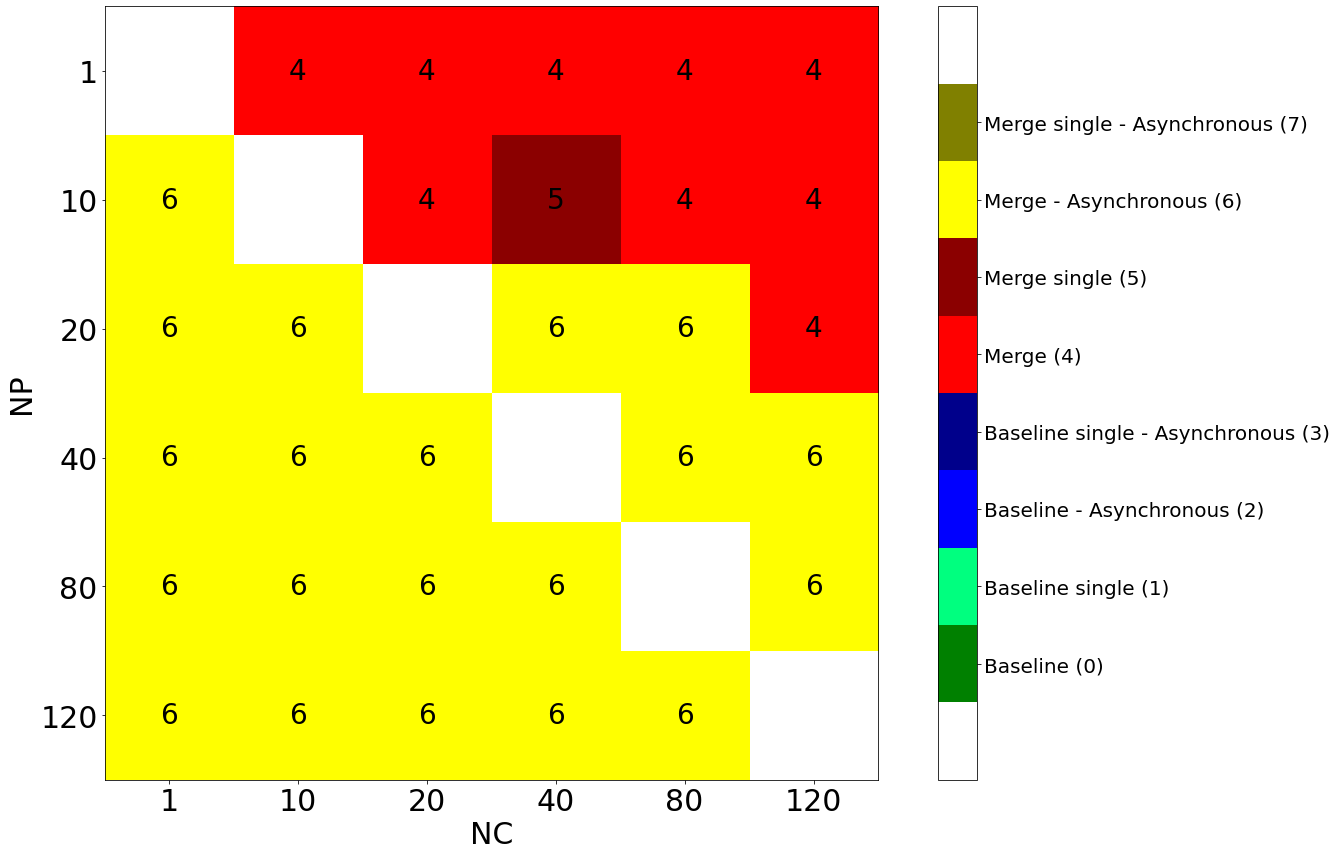

In [133]:
#Crea un heatmap teniendo en cuenta los colores anteriores
f=plt.figure(figsize=(20, 12))
ax=f.add_subplot(111)

myColors = (colors.to_rgba("white"),colors.to_rgba("green"), colors.to_rgba("springgreen"),colors.to_rgba("blue"),colors.to_rgba("darkblue"),
            colors.to_rgba("red"),colors.to_rgba("darkred"),colors.to_rgba("yellow"),colors.to_rgba("olive"),colors.to_rgba("white"))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

im = ax.imshow(heatmap,cmap=cmap,interpolation='nearest')

# Loop over data dimensions and create text annotations.
for i in range(len(processes)):
    for j in range(len(processes)):
        if i!=j:
            if heatmap[i, j] == 2 or heatmap[i, j] == 3:
                text = ax.text(j, i, heatmap[i, j],
                       ha="center", va="center", color="white", fontsize=28)
            else:
                text = ax.text(j, i, heatmap[i, j],
                       ha="center", va="center", color="black", fontsize=28)

ax.set_ylabel("NP", fontsize=30)
ax.set_xlabel("NC", fontsize=30)

ax.set_xticklabels(['']+processes, fontsize=30)
ax.set_yticklabels(['']+processes, fontsize=30)

#
labelsMethods_aux = ['Baseline (0)', 'Baseline single (1)','Baseline - Asynchronous (2)','Baseline single - Asynchronous (3)',
                 'Merge (4)','Merge single (5)','Merge - Asynchronous (6)','Merge single - Asynchronous (7)']
colorbar=f.colorbar(im, ax=ax)
colorbar.set_ticks([0.35, 1.25, 2.15, 3.05, 3.95, 4.85, 5.75, 6.65]) #TE
#colorbar.set_ticks([-2.55, 0.35, 1.25, 2.15, 3.05, 3.95, 4.85, 5.75, 6.65]) #TC
colorbar.set_ticklabels(labelsMethods_aux)
colorbar.ax.tick_params(labelsize=20)
#

f.tight_layout()
f.savefig("Images/Spawn/Heatmap_"+tipo+".png", format="png")

In [100]:
from sklearn import linear_model
import statsmodels.api as sm

Stock_Market = {'Year': [2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016],
                'Month': [12, 11,10,9,8,7,6,5,4,3,2,1,12,11,10,9,8,7,6,5,4,3,2,1],
                'Interest_Rate': [2.75,2.5,2.5,2.5,2.5,2.5,2.5,2.25,2.25,2.25,2,2,2,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75],
                'Unemployment_Rate': [5.3,5.3,5.3,5.3,5.4,5.6,5.5,5.5,5.5,5.6,5.7,5.9,6,5.9,5.8,6.1,6.2,6.1,6.1,6.1,5.9,6.2,6.2,6.1],
                'Stock_Index_Price': [1464,1394,1357,1293,1256,1254,1234,1195,1159,1167,1130,1075,1047,965,943,958,971,949,884,866,876,822,704,719]        
                }

df = pd.DataFrame(Stock_Market,columns=['Year','Month','Interest_Rate','Unemployment_Rate','Stock_Index_Price'])

X = df[['Interest_Rate','Unemployment_Rate']] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = df['Stock_Index_Price']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# prediction with sklearn
New_Interest_Rate = 2.75
New_Unemployment_Rate = 5.3
print ('Predicted Stock Index Price: \n', regr.predict([[New_Interest_Rate ,New_Unemployment_Rate]]))

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 1798.4039776258546
Coefficients: 
 [ 345.54008701 -250.14657137]
Predicted Stock Index Price: 
 [1422.86238865]
                            OLS Regression Results                            
Dep. Variable:      Stock_Index_Price   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     92.07
Date:                Tue, 15 Feb 2022   Prob (F-statistic):           4.04e-11
Time:                        16:10:06   Log-Likelihood:                -134.61
No. Observations:                  24   AIC:                             275.2
Df Residuals:                      21   BIC:                             278.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]

/home/usuario/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
